In [15]:
%matplotlib notebook

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import psana
from tqdm import tqdm
from utilities import *
from crosscor import *
from scipy.optimize import curve_fit

In [71]:
def gaussian(x, amp, cen, wid, bg):
                return amp * np.exp(-(x-cen)**2 /(2*wid**2))+bg
def fit_gaussian1_curveFit(a, n = 20,pdel = 3, printflag = 1,plotflag=1,color = 'blue',newplot = 0):
    x = np.arange(2*n)-n
    aroi = a.copy()
    x,z = makeFittingData(x,aroi,pdel = pdel)
    p0 = np.array([1.,0.,3.,1.])
    px,covx = curve_fit(gaussian,x, z ,p0)
    if plotflag:
        if newplot:
            plt.figure()
        xplot = np.linspace(0,n*2,600)-n
        zplot = gaussian(xplot,*px)
        plt.plot(xplot,zplot,color = color)
        x = np.arange(2*n)-n
        aroi = a.copy()   
        x,z = makeFittingData(x,aroi,pdel = pdel)
        plt.plot(x,z,'o',color = color)
        plt.xlabel('distance (pixel)')
        plt.ylabel('correlation')
        plt.tight_layout()   
    return px
def makeFittingData(x,z,pdel =3):
    for i in np.arange(pdel):
        z[z.argmax()] = 0
    ind = np.where(z>0)[0]
    x_pick = x[ind]
    z_pick = z[ind]
    return x_pick,z_pick
def getSpeckleProperties(f,E = 9.83, L = 5.43,ps = 50e-6):
    lam = 12.398/E
    width = f[2]*2.35
    s = 0.9*lam*L/(width*ps)*1e-10
    return width, s

In [8]:
run = 82
ds = psana.MPIDataSource('exp=xppl1001021:run={}:smd'.format(run))
#ds.break_after(100) # stop iteration after 3 events (break statements do not work reliably with MPIDataSource).
detname = 'epix_alc5'
det = psana.Detector(detname) 
crl_z_det = psana.Detector('crl_z') 
nimg = 100
i = 0
for nevt,evt in tqdm(enumerate(ds.events())):
    crl_z = crl_z_det(evt)
    if i == nimg: break
    if np.isclose(crl_z, 45):
        img = det.calib(evt)
        if i == 0:
            imgs = np.zeros(np.r_[nimg, img.shape])
        imgs[i] = img.copy()
        i += 1

10927it [00:25, 421.09it/s]


### average image analysis

In [10]:
aimg = np.mean(imgs, axis = 0)

<IPython.core.display.Javascript object>


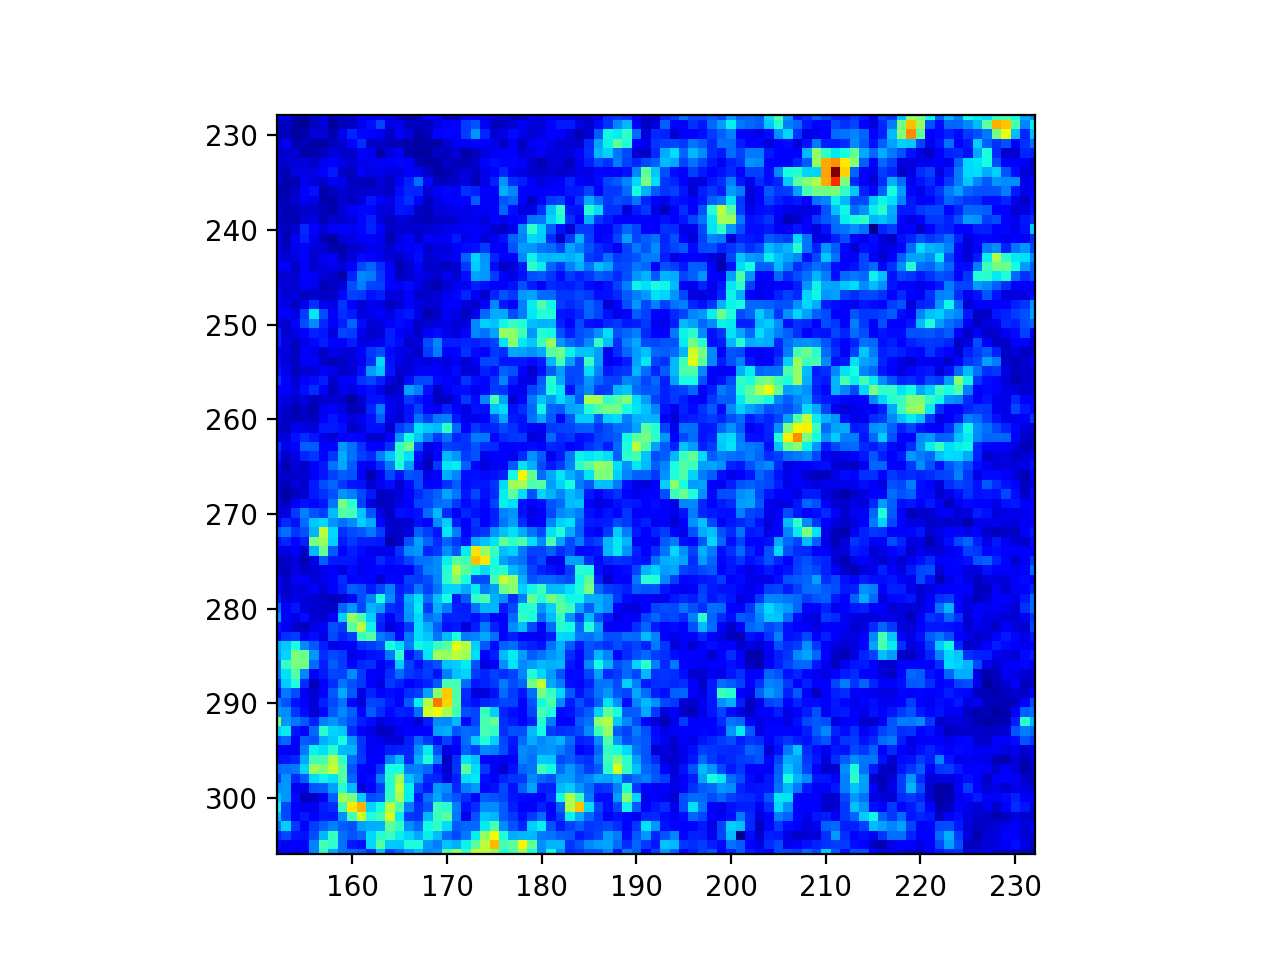

In [62]:
plt.figure()
plt.imshow(aimg, vmax = 40, cmap = 'jet')

<IPython.core.display.Javascript object>


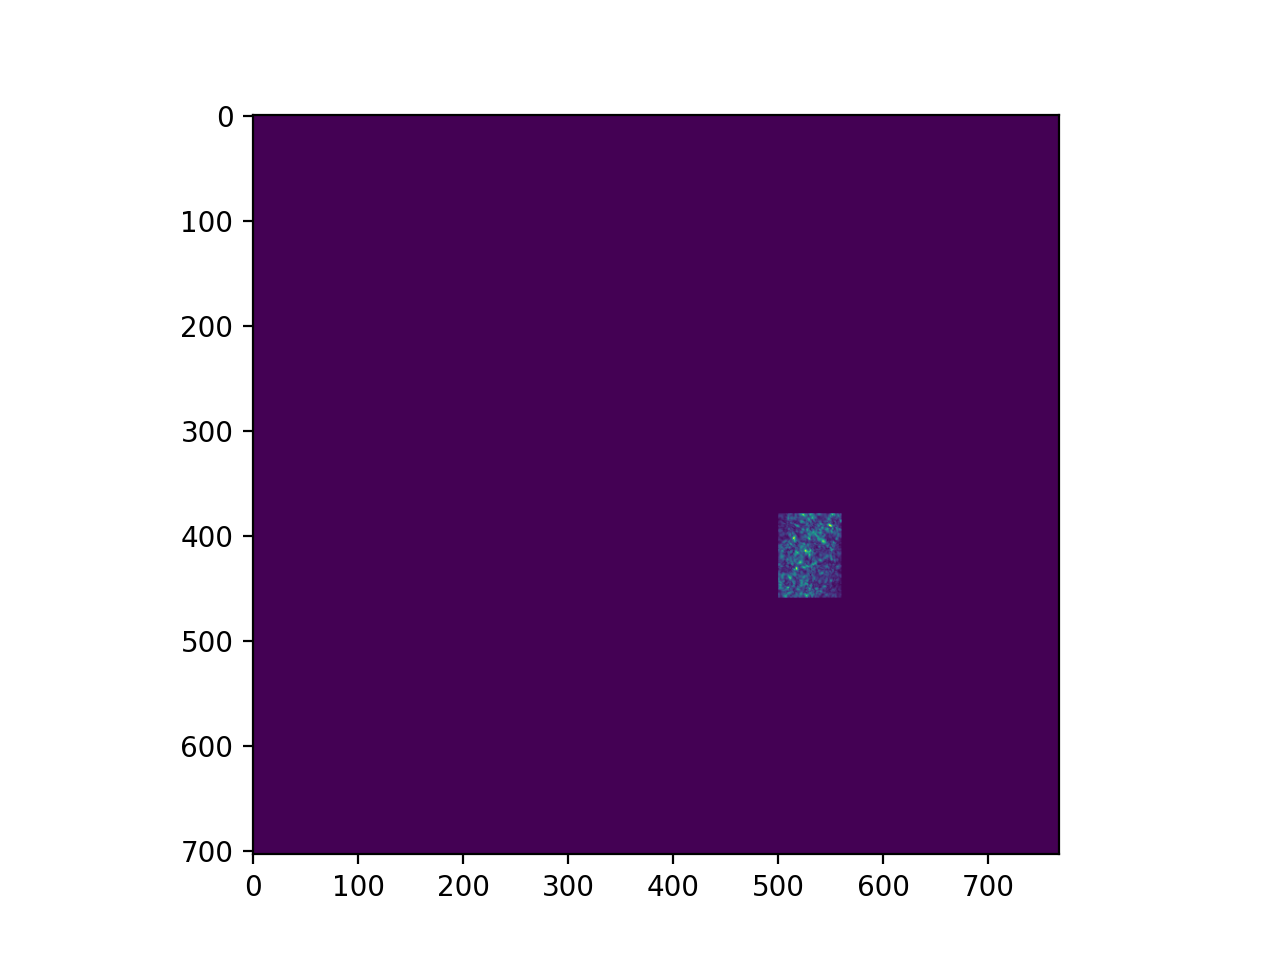

In [33]:
plt.figure()
plt.imshow(aimg*roi)

In [35]:
roi = np.zeros((aimg.shape))
roi[380:460,500:560] = 1
roi[490:560, 260:320] = 2
roi[260:320, 500:560] = 3
roi[150:210, 310:370] = 4
cc = crosscor(roi.shape, roi, 'symavg')

In [58]:
l = 20
autocorr = cc(aimg)
autocorr_center = np.zeros((int(roi.max()), 2*l, 2*l))
for i in range(int(roi.max())):
    ashape = autocorr[i].shape
    autocorr_center[i] = autocorr[i][ashape[0]//2-l:ashape[0]//2+l, ashape[1]//2-l:ashape[1]//2+l]

In [59]:
ave_autocorr = np.mean(autocorr_center, axis = 0)

<IPython.core.display.Javascript object>


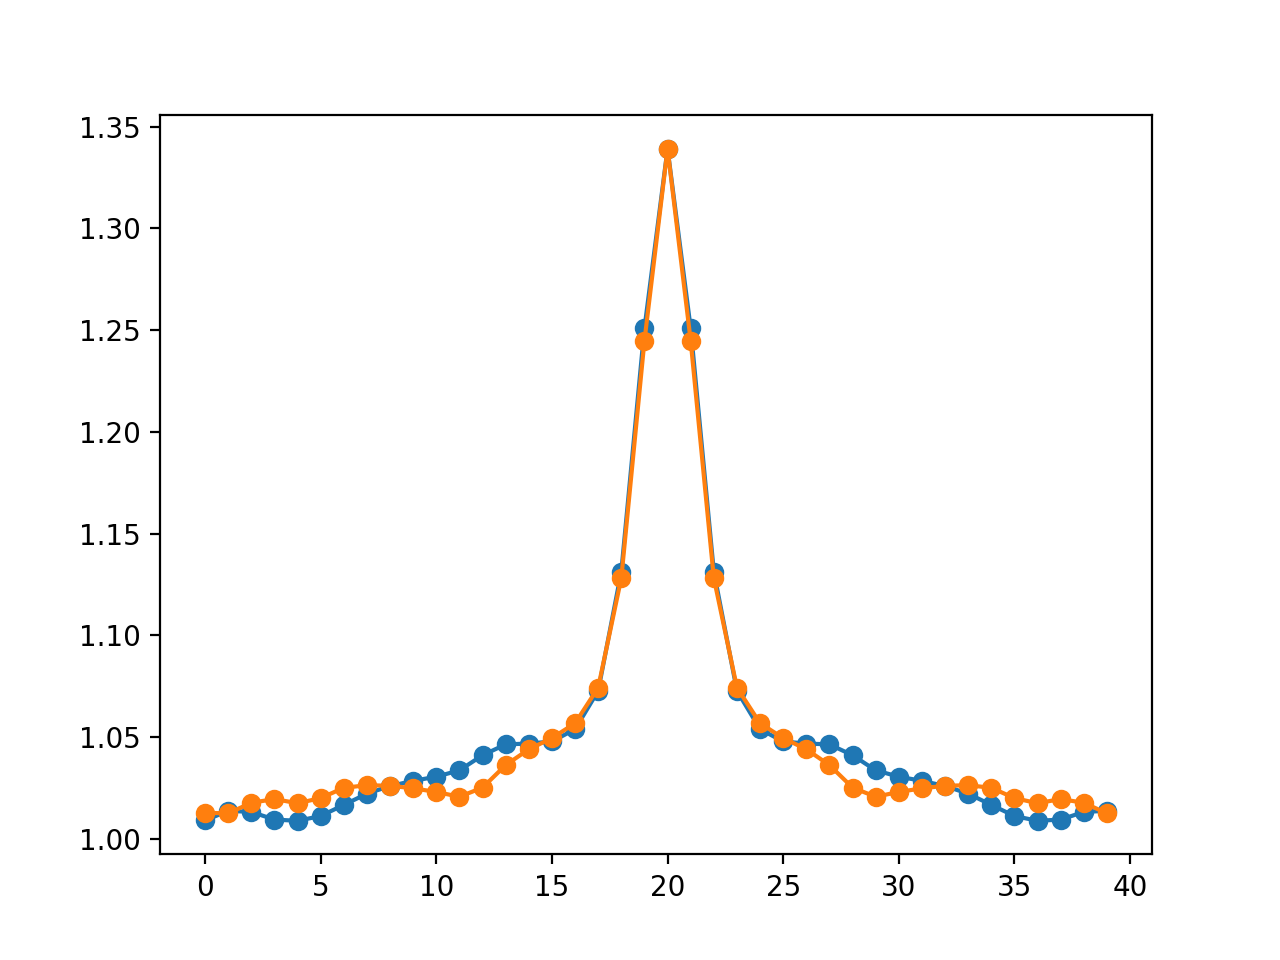

In [60]:
plt.figure()
plt.plot(ave_autocorr[l, :], 'o-')
plt.plot(ave_autocorr[:, l], 'o-')

<IPython.core.display.Javascript object>


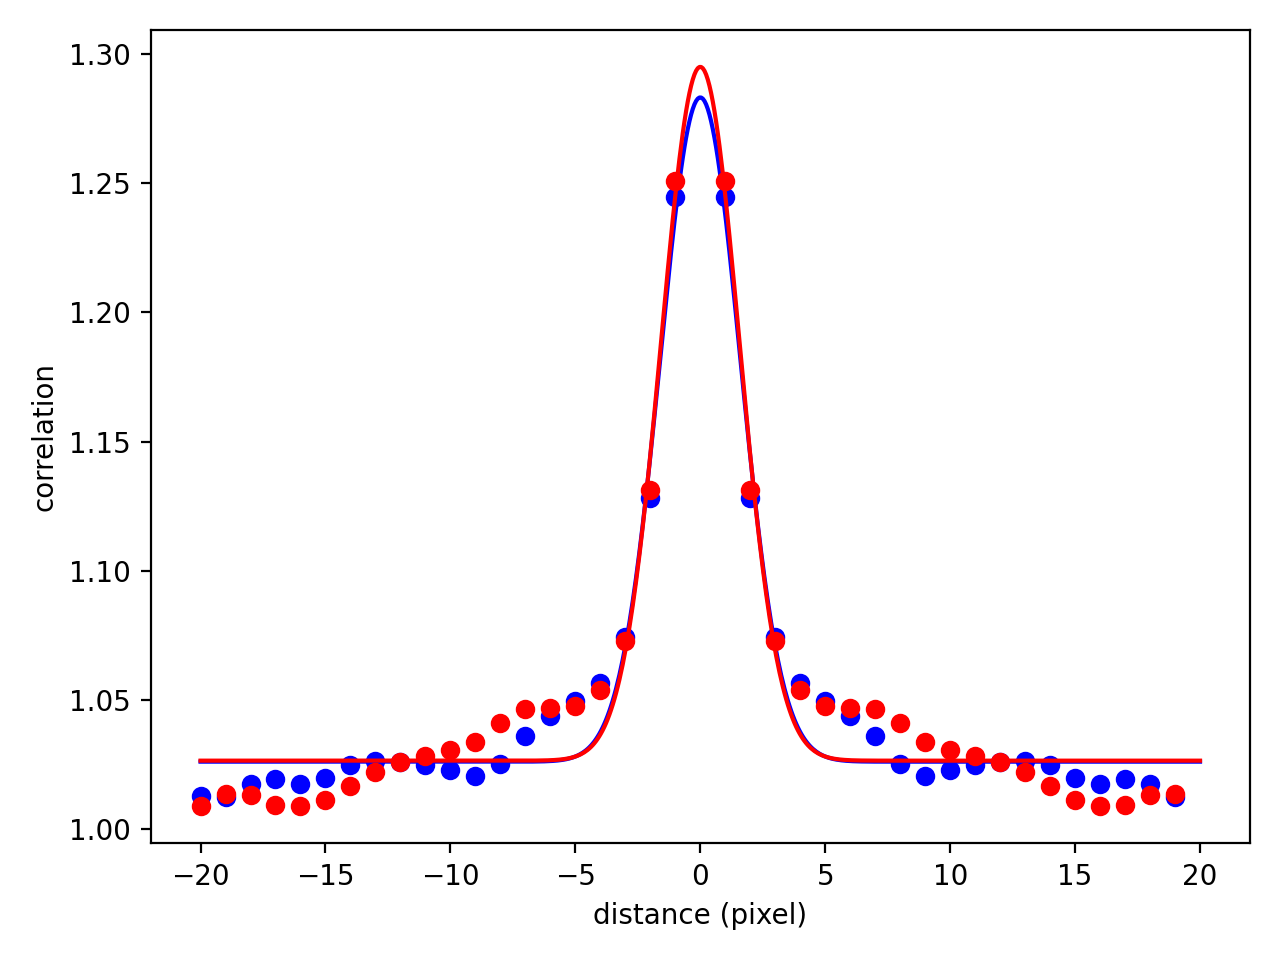

speckle size: 3.77 pixel, 3.67 pixel, beam size 2.69 micron, 2.77 micron


In [88]:
plt.figure()
fh = fit_gaussian1_curveFit(ave_autocorr[:, l], n =l, pdel = 1)
fv = fit_gaussian1_curveFit(ave_autocorr[l,:], n =l, color = 'r', pdel = 1)
widthx, beamx= getSpeckleProperties(fh,E = 9.5, L = 4.32,ps = 50e-6)
widthy, beamy = getSpeckleProperties(fv,E = 9.5, L = 4.32,ps = 50e-6)
print ('speckle size: {:.2f} pixel, {:.2f} pixel, beam size {:.2f} micron, {:.2f} micron'.format(widthx, widthy, beamx*1e6, beamy*1e6))

###  single shot analyis

In [97]:
autocorr_center_single_img = np.zeros((nimg, int(roi.max()), 2*l, 2*l))
ints = np.zeros((nimg))
for i in range(nimg):
    _a = cc(imgs[i])
    ints[i] = imgs[i][roi == 1].mean()
    for j in range(int(roi.max())):
        ashape = _a[j].shape
        autocorr_center_single_img[i,j] = _a[j][ashape[0]//2-l:ashape[0]//2+l, ashape[1]//2-l:ashape[1]//2+l]

In [98]:
ave_autocorr = np.average(autocorr_center_single_img.mean(axis = 1), axis = 0, weights=ints**2)

<IPython.core.display.Javascript object>


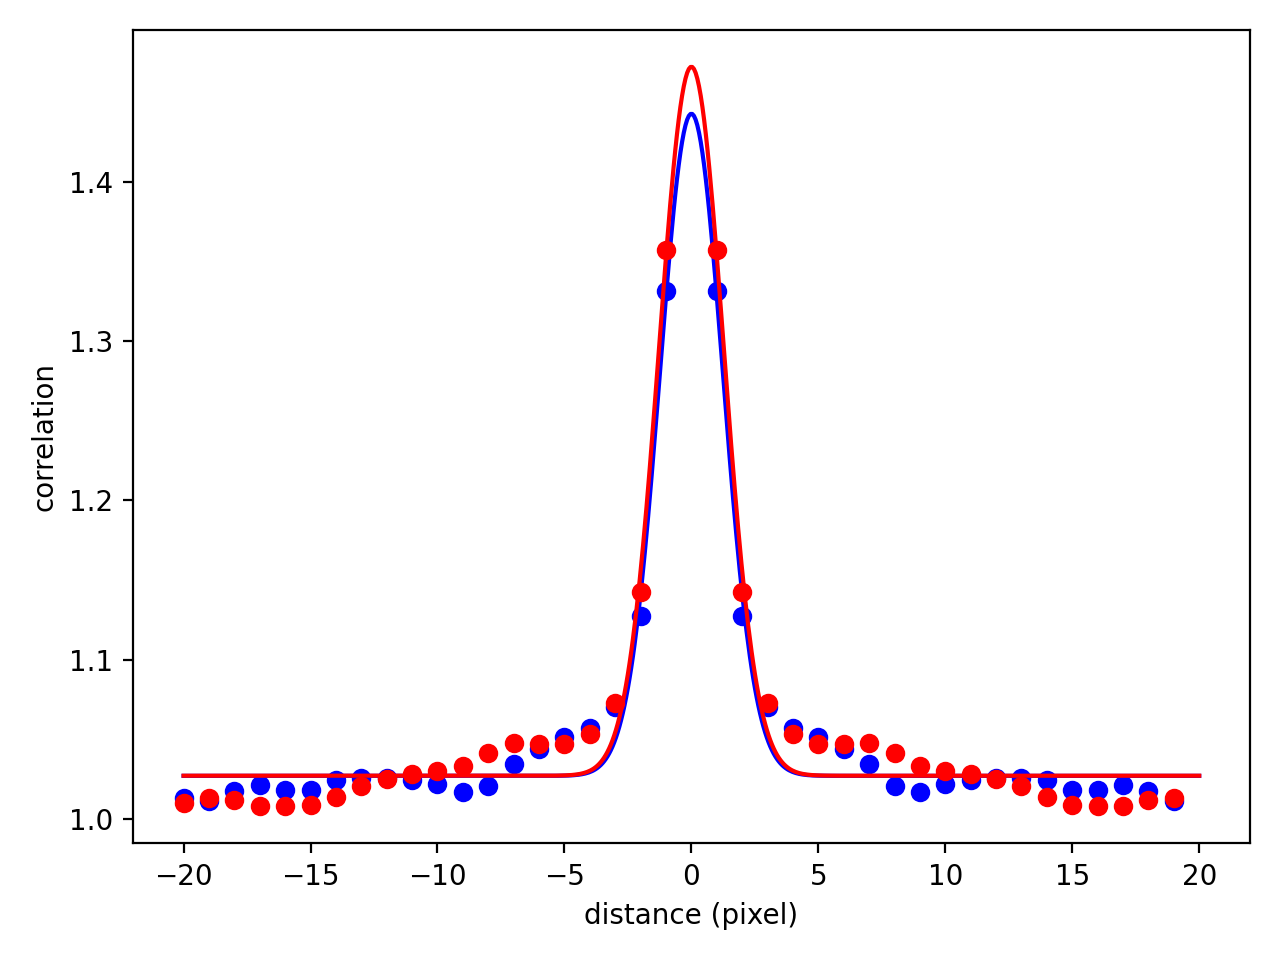

speckle size: 2.92 pixel, 2.98 pixel, beam size 3.47 micron, 3.40 micron


In [101]:
plt.figure()
fh = fit_gaussian1_curveFit(ave_autocorr[:, l], n =l, pdel = 1)
fv = fit_gaussian1_curveFit(ave_autocorr[l,:], n =l, color = 'r', pdel = 1)
widthx, beamx= getSpeckleProperties(fh,E = 9.5, L = 4.32,ps = 50e-6)
widthy, beamy = getSpeckleProperties(fv,E = 9.5, L = 4.32,ps = 50e-6)
print ('speckle size: {:.2f} pixel, {:.2f} pixel, beam size {:.2f} micron, {:.2f} micron'.format(widthx, widthy, beamx*1e6, beamy*1e6))